In [1]:
import sympy as sym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
#### Data by Nidula_Elgiriyewithana

In [3]:
apples = pd.read_csv("apple_quality.csv")

In [4]:
# drop the last row
# got rid of the A_id column
apples.dropna(inplace=True)
apples.drop(columns="A_id", inplace=True)

In [5]:
apples.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


## Summaries

In [6]:
apples.describe().transpose().round(4)

,count,mean,std,min,25%,50%,75%,max
Size,4000.0,-0.5030,1.9281,-7.1517,-1.8168,-0.5137,0.8055,6.4064
Weight,4000.0,-0.9895,1.6025,-7.1498,-2.0118,-0.9847,0.0310,5.7907
Sweetness,4000.0,-0.4705,1.9434,-6.8945,-1.7384,-0.5048,0.8019,6.3749
Crunchiness,4000.0,0.9855,1.4028,-6.0551,0.0628,0.9982,1.8942,7.6199
Juiciness,4000.0,0.5121,1.9303,-5.9619,-0.8013,0.5342,1.8360,7.3644
Ripeness,4000.0,0.4983,1.8744,-5.8646,-0.7717,0.5034,1.7662,7.2378


In [7]:
# correlation
corr = apples.loc[:, apples.columns != "Quality"].corr()
corr.style.background_gradient(cmap="viridis")

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,-0.170702,-0.324680,0.169868,-0.018892,-0.134773,0.196218
Weight,-0.170702,1.000000,-0.154246,-0.095882,-0.092263,-0.243824,0.016414
Sweetness,-0.324680,-0.154246,1.000000,-0.037552,0.095882,-0.273800,0.085999
Crunchiness,0.169868,-0.095882,-0.037552,1.000000,-0.259607,-0.201982,0.069943
Juiciness,-0.018892,-0.092263,0.095882,-0.259607,1.000000,-0.097144,0.248714
Ripeness,-0.134773,-0.243824,-0.273800,-0.201982,-0.097144,1.000000,-0.202669
Acidity,0.196218,0.016414,0.085999,0.069943,0.248714,-0.202669,1.000000


In [8]:
# Coefficient of Determination
R_squared = corr ** 2
R_squared.style.background_gradient(cmap="viridis")

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,0.029139,0.105417,0.028855,0.000357,0.018164,0.038502
Weight,0.029139,1.000000,0.023792,0.009193,0.008512,0.059450,0.000269
Sweetness,0.105417,0.023792,1.000000,0.001410,0.009193,0.074966,0.007396
Crunchiness,0.028855,0.009193,0.001410,1.000000,0.067396,0.040797,0.004892
Juiciness,0.000357,0.008512,0.009193,0.067396,1.000000,0.009437,0.061859
Ripeness,0.018164,0.059450,0.074966,0.040797,0.009437,1.000000,0.041075
Acidity,0.038502,0.000269,0.007396,0.004892,0.061859,0.041075,1.000000


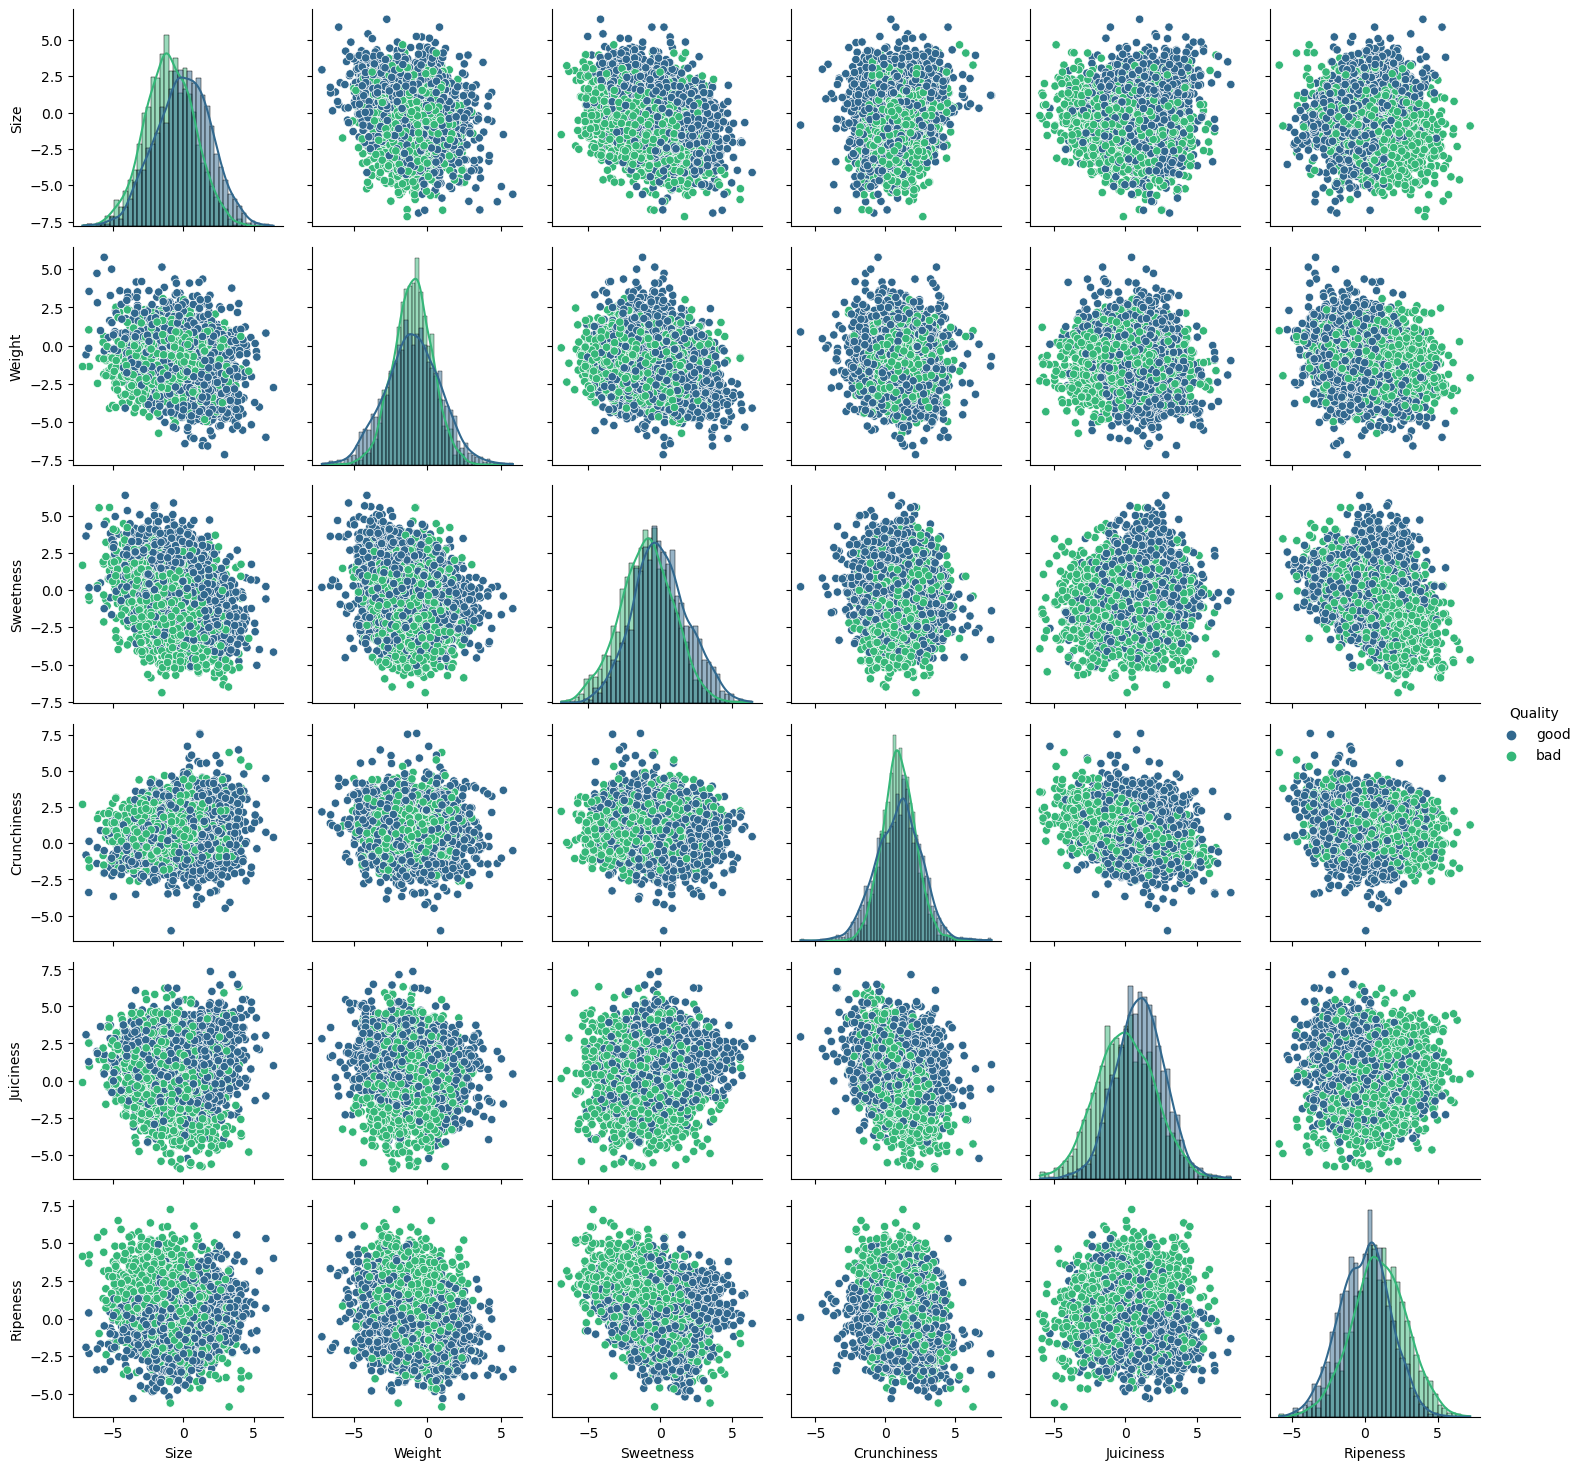

In [9]:
g = sns.PairGrid(apples, hue='Quality', palette='viridis')

g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

From the correlation matrix and scatterplot matrix, we can observe that there are weak correlations between variables. The strongest correlation has a coefficient of determination of 0.1054. Each variable appears approximately normal, mainly when grouped by apple quality. As a result, we will perform a hypothesis testing for the difference of means and an F-test for the variance of size and sweetness. We will then create a model representing the distribution of size and sweetness. Despite the weak correlation, we will develop a linear model of size versus sweetness.

## hypothesis test for sizes and sweetness
### First we will focus on the size

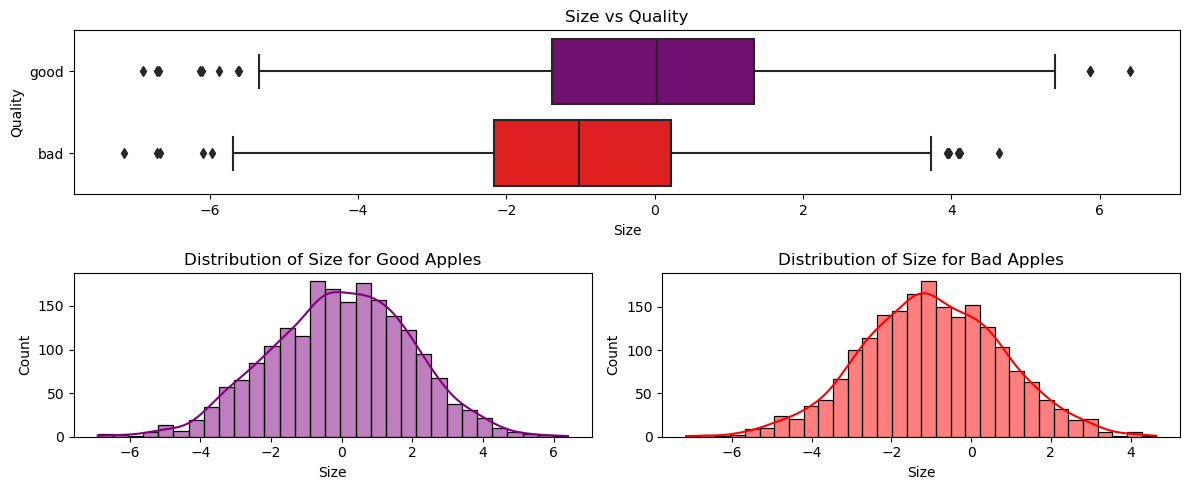

In [10]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(2,1,1)
sns.boxplot(data=apples, x=apples['Size'], y=apples['Quality'], palette=['Purple', 'Red'])
ax1.set_title("Size vs Quality")

ax2 = plt.subplot(2,2,3)
sns.histplot(apples[apples['Quality'] == 'good'].Size, color='Purple', kde=True)
ax2.set_title("Distribution of Size for Good Apples")

ax3 = plt.subplot(2,2,4)
sns.histplot(apples[apples['Quality'] == 'bad'].Size, color ='Red', kde = True)
ax3.set_title("Distribution of Size for Bad Apples")

plt.tight_layout()
plt.show()

In [11]:
size_summary = apples.groupby('Quality')['Size'].describe()

# mean
bad_size_mean = size_summary.loc['bad']['mean']
good_size_mean = size_summary.loc['good']['mean']

# var
bad_size_var = size_summary.loc['bad']['std'] ** 2
good_size_var = size_summary.loc['good']['std'] ** 2

print(f"The mean for bad and good apples respectively are {bad_size_mean:.4f} and {good_size_mean:.4f}.",
     f"For their variance they are {bad_size_var:.4f} and {good_size_var:.4f}")
size_summary

The mean for bad and good apples respectively are -0.9744 and -0.0336. For their variance they are 3.1028 and 3.8895


,count,mean,std,min,25%,50%,75%,max
Quality,,,,,,,,
bad,1996.0,-0.974358,1.761477,-7.151703,-2.169909,-1.019633,0.221546,4.649923
good,2004.0,-0.033553,1.972189,-6.905803,-1.379540,0.025554,1.344088,6.406367


As the data is normally distributed and the true variance is unknown, we will be using the t-test. However, before proceeding, we need to test the variance to determine whether we can assume equal variances.

## Hypothesis
Let $\sigma^2_1$ represent the population variance for the size of **bad** apples and Let $\sigma^2_2$ represent the population variance for the size of **good** apples. Then, our hypothesis are:
$$H_0:\frac{\sigma^2_1}{\sigma^2_2}=1 \qquad H_1:\frac{\sigma^2_1}{\sigma^2_2}\ne1$$

In [12]:
# Let's serperate the bad apples with the good ones
bad_apples = apples[apples['Quality'] == 'bad']
good_apples = apples[apples['Quality'] == 'good']

# we will be performing a two-tailed F-test
F_test_statistics = round(bad_size_var / good_size_var, 4) # 0.7977

# numerator degrees of freedom and denominator degrees of freedom
ndf = bad_apples.Size.count() - 1 # 1995
ddf = good_apples.Size.count() - 1 # 2003

p_value = stats.f.cdf(F_test_statistics, ddf, ndf) * 2

F_test_statistics, p_value

(0.7977, 4.4841720803976256e-07)

## Conclusion
Since the p-value is less than 0.01, we reject the null hypothesis at the 1% significance level. We will proceed with the Welch's t-test.

## Hypothesis
Let $\mu_1$ represent the population mean for the size of bad apples and Let $\mu_2$ represent the population mean for the size of good apples. Then, our hypothesis are:
$$H_0:\mu_1 - \mu_2 = 0\qquad H_1:\mu_1 - \mu_2 \ne 0$$

In [13]:
test_statistic, Pval = stats.ttest_ind(bad_apples.Size, good_apples.Size, equal_var = False)
test_statistic, Pval

(-15.912978326846408, 2.6022039712273326e-55)

## Conclusion
As our p-value is less than 0.01, we reject the null hypothesis at a 1% significance level, supporting that the mean is not equal.

### Next we focus on Sweetness

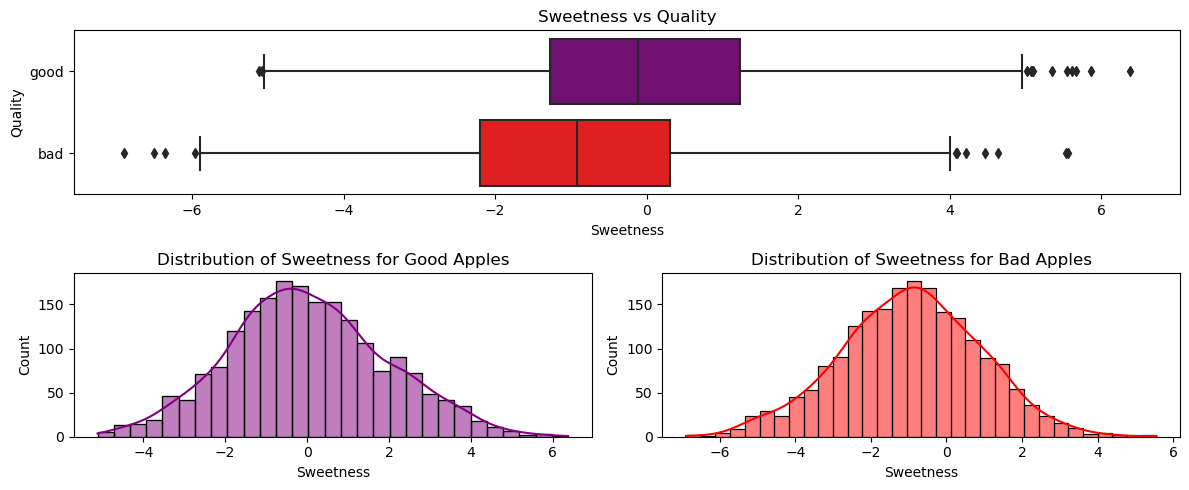

In [14]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(2,1,1)
sns.boxplot(data=apples, x=apples['Sweetness'], y=apples['Quality'], palette=['Purple', 'Red'])
ax1.set_title("Sweetness vs Quality")

ax2 = plt.subplot(2,2,3)
sns.histplot(apples[apples['Quality'] == 'good'].Sweetness, color='Purple', kde=True)
ax2.set_title("Distribution of Sweetness for Good Apples")

ax3 = plt.subplot(2,2,4)
sns.histplot(apples[apples['Quality'] == 'bad'].Sweetness, color ='Red', kde = True)
ax3.set_title("Distribution of Sweetness for Bad Apples")

plt.tight_layout()
plt.show()

In [15]:
sweet_summary = apples.groupby('Quality')['Sweetness'].describe()

# mean
bad_sweet_mean = sweet_summary.loc['bad']['mean']
good_sweet_mean = size_summary.loc['good']['mean']

# var
bad_sweet_var = sweet_summary.loc['bad']['std'] ** 2
good_sweet_var = sweet_summary.loc['good']['std'] ** 2

print(f"The mean for bad and good apples respectively are {bad_sweet_mean:.4f} and {good_sweet_mean:.4f}.",
     f"For their variance they are {bad_sweet_var:.4f} and {good_sweet_var:.4f}")

sweet_summary

The mean for bad and good apples respectively are -0.9592 and -0.0336. For their variance they are 3.4306 and 3.6488


,count,mean,std,min,25%,50%,75%,max
Quality,,,,,,,,
bad,1996.0,-0.959195,1.852182,-6.894485,-2.194897,-0.921758,0.312889,5.559624
good,2004.0,0.016287,1.910178,-5.118948,-1.281629,-0.116781,1.236140,6.374916


We will peform the same method as we did with size of the apple

## Hypothesis
Let $\sigma^2_1$ represent the population variance for the sweetness of **bad** apples and Let $\sigma^2_2$ represent the population variance for the sweetness of **good** apples. Then, our hypothesis are:
$$H_0:\frac{\sigma^2_1}{\sigma^2_2}=1 \qquad H_1:\frac{\sigma^2_1}{\sigma^2_2}\ne1$$

In [16]:
# we will be performing a two-tailed F-test
F_test_statistics = round(bad_sweet_var / good_sweet_var, 4) 

# numerator degrees of freedom and denominator degrees of freedom
ndf = bad_apples.Sweetness.count() - 1 # 1995
ddf = good_apples.Sweetness.count() - 1 # 2003

p_value = stats.f.cdf(F_test_statistics, ddf, ndf) * 2

F_test_statistics, p_value

(0.9402, 0.1681266884741872)

## Conclusion
Since the p-value is more significant than 0.1, we fail to reject the null hypothesis at the 10% significance level. Therefore, we support the idea that the population variance may be equal. Thus, we will be using the student's t-test.

## Hypotheses
Let $\mu_1$ represent the population mean for the sweetness of **bad** apples and Let $\mu_2$ represent the population mean for the sweetness of **good** apples. Then, our hypotheses are:
$$H_0:\mu_1 - \mu_2 = 0\qquad H_1:\mu_1 - \mu_2 \lt 0$$

In [17]:
test_statistic, Pval = stats.ttest_ind(bad_apples.Sweetness, good_apples.Sweetness, equal_var = True, alternative='less')
test_statistic, Pval

(-16.39542605290574, 8.052353982468732e-59)

## Conclusion
Since our p-value is less than 0.01, we have significant evidence to reject the null hypothesis at the 1% significant level, thus supporting that, on average, bad apples are less sweet than good apples.

## Linear regression analysis
We will perform a linear regression analysis with the sweetness of the apple as the response variable and the size as the explanatory variable.

In [18]:
model = sm.OLS.from_formula('Sweetness ~ Size', apples)
results = model.fit()
results.params

Intercept   -0.635100
Size        -0.327271
dtype: float64

In [23]:
# calculate fitted_values
fitted_values = results.predict(apples)

SST = sum((apples.Sweetness - apples.Sweetness.mean()) ** 2) # total sum of squares
SSE = sum((apples.Sweetness - fitted_values) ** 2) # error sum of squares
SSR = sum((fitted_values - apples.Sweetness.mean()) ** 2) # regression sum of squares

print(f"SST: {SST}\nSSE: {SSE}\nSSR: {SSR}")
SSE + SSR, SSR / SST

SST: 15104.069417385925
SSE: 13511.839737255488
SSR: 1592.229680130384


(15104.069417385872, 0.10541726445573717)

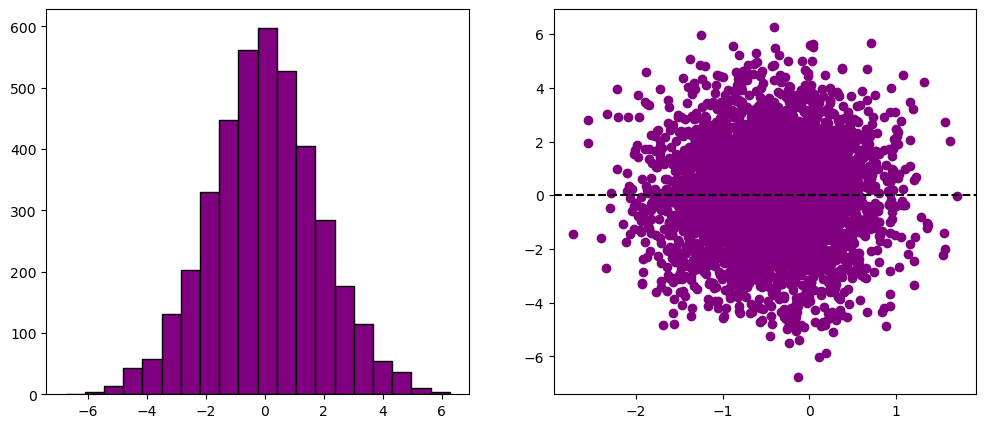

In [22]:
residuals = apples.Sweetness - fitted_values
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].hist(residuals, bins = 20, edgecolor="Black", color='Purple')
axs[1].scatter(fitted_values, residuals, color='Purple')
axs[1].axhline(y=0, color='Black', linestyle='--')

plt.show()

Notice the assumption of normality and homoscedasticity are met

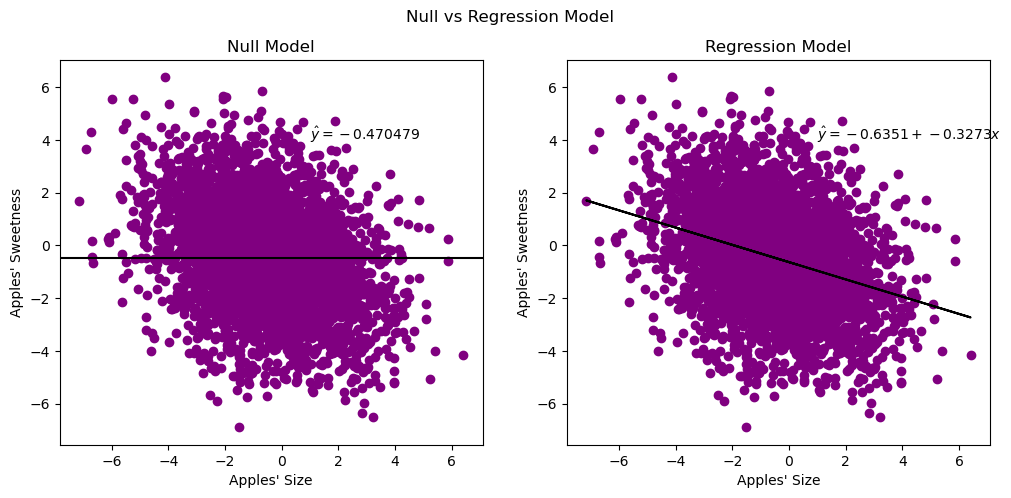

In [21]:
sweet_mean_array = np.full(apples.Sweetness.count(), apples.Sweetness.mean())
beta_0 = round(results.params[0],4)
beta_1 = round(results.params[1],4)

fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Null vs Regression Model")
axs[0].scatter(apples.Size, apples.Sweetness, color='Purple')
axs[0].set_title('Null Model')
axs[0].set_xlabel("Apples' Size")
axs[0].set_ylabel("Apples' Sweetness")
axs[0].axhline(y=apples.Sweetness.mean(), color='Black')
axs[0].text(1,4, "$\hat{y}=%g$" %(apples.Sweetness.mean()))

axs[1].scatter(apples.Size, apples.Sweetness, color='Purple')
axs[1].set_title('Regression Model')
axs[1].set_xlabel("Apples' Size")
axs[1].set_ylabel("Apples' Sweetness")
axs[1].plot(apples.Size, fitted_values, '-', color='Black')
axs[1].text(1,4, "$\hat{y}= %g + %gx$" %(beta_0, beta_1))
plt.show()

## Hypotheses
We will now test if there is any relationship between the response and the explanatory variable. Therefore our hypotheses will be the following:
$$H_0: \beta_1 = 0 \qquad H_1: \beta_1 \ne 0$$
test statistic will be the following:
$$t.s. = \frac{\hat{\beta_1}-h}{se\left(\hat{\beta_1}\right)}$$

In [55]:
MSE = SSE / (apples.Sweetness.count() - 2) # Mean square error
se_beta_1 = np.sqrt(MSE / sum( (apples.Size - apples.Size.mean()) ** 2)) # standard error for beta_1
test_statistic = (beta_1 - 0) / se_beta_1 
df = apples.Sweetness.count() - 2

pval = stats.t.cdf(test_statistic, df=df) * 2
test_statistic, pval

(-21.707315024788937, 7.269571338571796e-99)

## Conclusion
since our p-value is significant at the 0.1% level, we reasonbly conclude there is a meaningful relationship between the size of the apple and its sweetness

## Monte Carlo Simulation

In [72]:
#df.sample(frac=0.5, replace=True, random_state=1)
def betas(subdata):
    model = sm.OLS.from_formula('Sweetness ~ Size', subdata) #may change "Sweetness ~ Size"
    results = model.fit()
    fitted_values = results.predict(subdata)
    return results.params[0], results.params[1], fitted_values   
    
def mean_square_error(subdata, fitted_values, n):
    SST = sum((subdata.Sweetness - fitted_values) ** 2)
    MSE = SST / (n-2)
    return MSE

def bootstrap(data, sample_size, boot_samples):
    beta_list = []
    
    for i in range(boot_samples):
        subdata = data.sample(n=sample_size, replace = True)
        beta_0, beta_1, fitted_values = betas(subdata)
        MSE = mean_square_error(subdata, fitted_values, sample_size)
        #equation = '$\hat{y}_{%g} = %g + %gx$' %(i, round(beta_0, 4), round(beta_1, 4))
        beta_list.append((beta_0, beta_1, MSE))
    
    return beta_list

In [78]:
boot_regression = pd.DataFrame(bootstrap(apples, apples.Size.count(), 1000), columns = ['beta_0', 'beta_1', 'MSE'])
boot_regression.head()

,beta_0,beta_1,MSE
0,-0.612114,-0.312328,3.329634
1,-0.597367,-0.304660,3.431843
2,-0.647504,-0.332086,3.328421
3,-0.621881,-0.325528,3.501233
4,-0.669680,-0.306186,3.378681


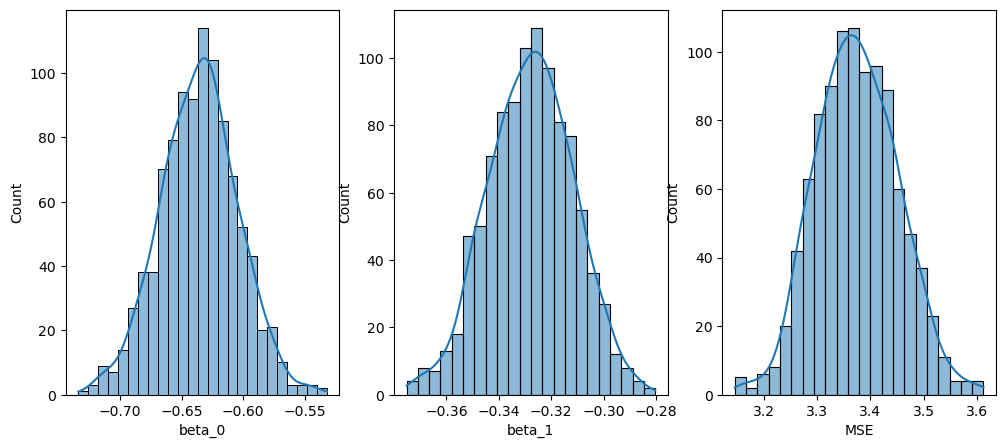

In [92]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

sns.histplot(ax=axs[0], x=boot_regression.beta_0, kde=True)
sns.histplot(ax=axs[1], x=boot_regression.beta_1, kde=True)
sns.histplot(ax=axs[2], x=boot_regression.MSE, kde=True)
plt.show()

goals for the future with this projects
- create a model that will predict the quality of the apple